In [16]:
%load_ext autoreload
%autoreload 2

# import importers
# import importlib
# importlib.reload(importers)
import importers
from importers import SpikeImporter

data_folder = "../data/"
file_name = "20_05_13_U1a_4960s_5400s"
file_ending = ".csv"

time_channel = "Time"
signal_channel = "1 Signal"
stimulus_channel = "32 DigMark"
ap_marker_channels = ["3 nw-1"]
extra_stimuli_channel = "801 DigMark"

# load the animal file
importer = SpikeImporter(filepath = data_folder + file_name + file_ending, time_channel = time_channel, signal_channel = signal_channel)

print("Data loaded.")

# define the max. time so that two sequential waveform-values are belonging to the same AP
# the time is in seconds, so 0.005 equals 5ms
max_gap_time = 0.005

# retrieve the events from the importer 
el_stimuli = importer.getElectricalStimuli(regular_stimulus_channel = stimulus_channel)
el_extra_stimuli = importer.getExtraStimuli(extra_stimulus_channel = extra_stimuli_channel, regular_el_stimuli = el_stimuli, verbose = False)
actpots = importer.getActionPotentials(max_gap_time = max_gap_time, ap_marker_channels = ap_marker_channels, \
                                      el_stimuli = el_stimuli, mech_stimuli = [], el_extra_stimuli = el_extra_stimuli, verbose = False)
# raw_signal = importer.getRawSignalSplitByStimuli(el_stimuli = el_stimuli, verbose = True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Data loaded.
List of eletrical stimuli created.
List of extra eletrical stimuli created.
Finished processing AP channel 1 out of 1
List of APs created.


In [17]:
''' 
This cell performs the clustering according to
- distance to previous stimulus
- normalized signal energy of the APs
'''
%autoreload 2
from metrics import clustering_metrics
from sklearn.cluster import DBSCAN
import numpy as np

# build feature vectors from the features provided by AP class
features = np.array([[ap.getDistanceToPreviousRegularElectricalStimulus(), ap.getNormalizedEnergy()] for ap in actpots])
channel_indices = np.array([ap.getChannelIndex() for ap in actpots])
labels = DBSCAN(eps = 0.005, min_samples = 10, metric = clustering_metrics.TimeDistAndEnergy, metric_params = {'energy_importance': 0}).fit_predict(features)
print("Clustering done.")

Clustering done.


c:\users\fabia\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


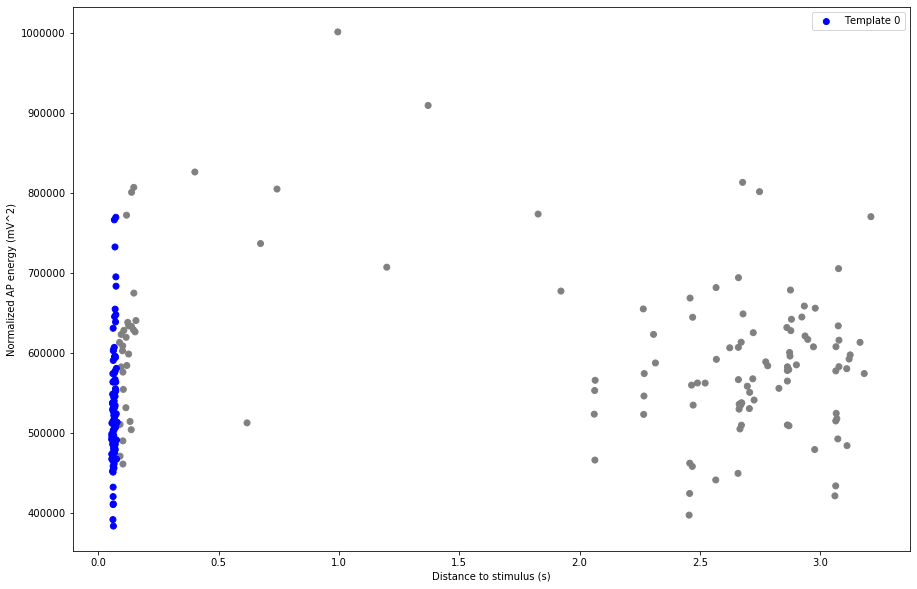

In [18]:
import matplotlib.pyplot as plt

markers = ['o', 'x', 's', 'D']
cluster_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'gray']

# where to save the results
results_folder = "../results/"
results_ending = ".png"

# initialize figure
fig = plt.figure(figsize = (15, 10))

channel_index = 0
while channel_index <= max(channel_indices):
    # get a mask for all APs from this channel
    indices = (channel_indices == channel_index)
    
    # get the 'cut' list of features and the colors corresponding to their cluster membership
    channel_features = features[indices, :]
    colors = np.array([cluster_colors[label % len(cluster_colors)] for label in labels])
    colors = colors[indices]
    
    # plot APs with marker according to channel index
    plt.scatter(x = channel_features[:, 0], y = channel_features[:, 1], c = colors, marker = markers[channel_index], label = "Template " + str(channel_index))
    
    channel_index = channel_index + 1

    
plt.xlabel("Distance to stimulus (s)")
# plt.xscale('log')
# plt.xlim(0, 0.1)
# plt.xlim(0.24, 0.26)
plt.ylabel("Normalized AP energy (mV^2)")
plt.legend()

fig.show()
fig.savefig(results_folder + "dbscan_clustering_" + file_name + results_ending, dpi = 400)

Starting at 201.6086s
Cropped interval from 201.60855s to 205.6088s
Cropped interval from 205.6088s to 209.60905s
Cropped interval from 209.60905s to 213.6093s
Cropped interval from 213.6093s to 217.60955s
Cropped interval from 217.60955s to 221.60975s
Cropped interval from 221.60975s to 225.6103s
Cropped interval from 225.6103s to 229.61055s
Cropped interval from 229.61055s to 233.6108s
Cropped interval from 233.6108s to 237.61105s
Cropped interval from 237.61105s to 241.61125s
Cropped interval from 241.61125s to 245.6115s
Cropped interval from 245.6115s to 249.61175s
Cropped interval from 249.61175s to 253.612s
Done with cropping the intervals


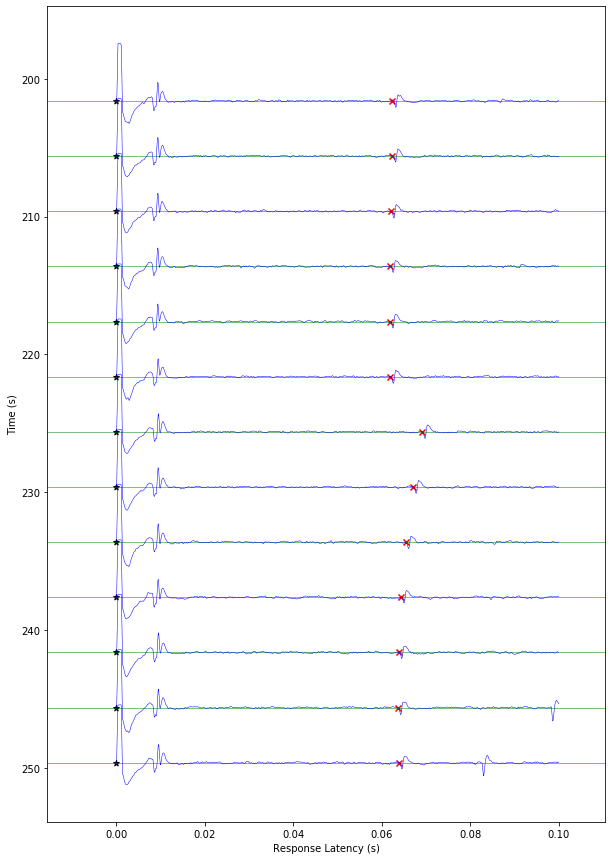

Figure saved.


In [19]:
%autoreload 2
from plotting import FallingLeafPlot
import itertools

analysis_start = 200
analysis_stop = 250

clusters_to_plot = [0]
indices = [(True if lbl in clusters_to_plot else False) for lbl in labels]
track_aps = list(itertools.compress(actpots, indices))

# get the raw signal from the data
raw_signal_intervals = importer.getRawSignalSplitByStimuli(el_stimuli = el_stimuli, verbose = True, start_time = analysis_start, stop_time = analysis_stop)
max_signal = max([max(interval) for interval in raw_signal_intervals])

flplot = FallingLeafPlot()
flplot.plot(regular_stimuli = el_stimuli, action_potentials = track_aps, plot_raw_signal = True, max_signal_value = max_signal, time_start = analysis_start, time_stop = analysis_stop, post_stimulus_timeframe = 0.1)
flplot.save_to_file(filename = "../results/falling_leaf_" + file_name + ".png")